## This notebooks is used to generate Figure 2 in the paper.

In [11]:
%matplotlib inline

import os
import sys
sys.path.append('../')
import pickle

import numpy as np
import scipy.stats as st
from scipy.special import logsumexp
from scipy.stats import norm, gamma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import yaml

In [12]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [17]:
def autocorr(x):
    x = np.copy(x)
    x -= np.mean(x)
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):] / np.linalg.norm(x)**2 

def get_all_lambdas(gibbs_folder_path, vi_folder_path, gt_file_path):
    
    gen_data_file = os.path.join(gt_file_path, 'data.p')
    gibbs_res_file = os.path.join(gibbs_folder_path, 'inference_results.p')
    yml_input_file = os.path.join(gibbs_folder_path, 'data_input.yml')

    with open(gen_data_file, 'rb') as f:
        gen_data = pickle.load(f)

    with open(gibbs_res_file, 'rb') as f:
        gibbs_samps = pickle.load(f)

    with open(yml_input_file, 'rb') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
        intensity_bound_gt = config['intensity_bound']
        T = config['time_bound']
        sample_hypers = config['sample_hyper']
        lambda_a_prior = config['lambda_a_prior']
        lambda_b_prior = config['lambda_b_prior']
        
    num_samps = len(gibbs_samps[0])
    burnin = int(0.5 * num_samps)

    events = gen_data[0][0]
    num_events = len(events)
    gibbs_intensity_bound = gibbs_samps[0][burnin:-2]

    vi_res = os.path.join(vi_folder_path, 'inference_results.p')
    with open(vi_res, 'rb') as f:
        LB_list, mu_g_X, mu_g2_X, hyper_params_list, \
        induced_points, integration_points, Kss_inv, ks_int_points, \
        ks_X, real_events, Sigma_g_s, mu_g_s, intensity_limit_vi_mean, \
        alpha_q1, beta_q1, test_like = pickle.load(f)
    vi_pred_int = os.path.join(vi_folder_path, 'pred_int.p')
    with open(vi_pred_int, 'rb') as f:
        vi_grid, predictive_intensities_vi_mean, predictive_intensities_vi_var = pickle.load(f)

    gt_pred_int = os.path.join(gt_file_path, 'intensities.p')
    with open(gt_pred_int, 'rb') as f:
        x_grid, intensities = pickle.load(f)

    gibbs_pred_int_file = os.path.join(gibbs_folder_path, 'pred_int.p')
    with open(gibbs_pred_int_file, 'rb') as f:
        grid, predictive_density_gibbs = pickle.load(f)

    phis_samps = gibbs_samps[1][burnin:-2, :]
    
    intensity_limit_vi_var = alpha_q1 /  beta_q1 ** 2

                
    return gibbs_intensity_bound, intensity_bound_gt, lambda_a_prior, lambda_b_prior, num_events, \
            intensity_limit_vi_mean, intensity_limit_vi_var, events, \
            intensities, x_grid, vi_grid, predictive_intensities_vi_mean, predictive_intensities_vi_var, \
            predictive_density_gibbs.mean(axis=1), predictive_density_gibbs.var(axis=1), \
            LB_list, mu_g_X, gen_data[1], phis_samps.mean(axis=0), alpha_q1, beta_q1

def plot_int_autocorr(samps, axis):
    burnin = 2000
    res = autocorr(samps[burnin:])
    axis.plot(res, color='#ff7f0e')
    axis.set_xlabel('Lag \n (c)')

def plot_for_res(gt_pred_int, vi_pred_int_mean, vi_pred_int_var, gibbs_pred_int_mean, gibbs_pred_int_var, grid, gibbs_lambda, gt_lambda, prior_a, prior_b, vi_lambda, vi_elbo, real_events,
                phis_vi, phis_gt, phis_gibbs, alpha_vi, betta_vi):
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.45, hspace=0.45)
    
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(grid.flatten(), gt_pred_int.flatten(), label='Ground Truth', color='C3')
    ax1.plot(grid.flatten(), vi_pred_int_mean, label='VI', color='#2ca02c')
    ax1.plot(grid.flatten(), gibbs_pred_int_mean, label='Gibbs', color='C1')
    ax1.plot(real_events, np.repeat(0, len(real_events)), '|', color='C7', label='Observations')
    ax1.set_xlabel('Time \n (a)')
    ax1.set_ylabel('Predictive Intensity')
    ax1.legend(loc='lower left', bbox_to_anchor= (0.8, 1.01), ncol=2,
            borderaxespad=0, frameon=False)
    
    ax2 = fig.add_subplot(gs[0, 2:])
    ax2.plot(real_events, phis_gt[0], '.--', color='C3', label='GT', markersize=6, linewidth=0.7)
    ax2.plot(real_events, phis_vi, '.--', label='VI', color='#2ca02c', markersize=6, linewidth=0.7)
    ax2.plot(real_events, phis_gibbs, '.--', label='Gibbs', color='C1', markersize=6, linewidth=0.7)
    ax2.plot(real_events, np.repeat(-2.5, len(real_events)), '|', color='C7', label='Observations')
    ax2.set_xlabel('Time \n (b)')
    ax2.set_ylabel(r'Linear intensity')
    
    ax3 = fig.add_subplot(gs[1, 0])
    burnin = 2000
    samps_array = np.array(gibbs_lambda)[burnin:]
    x = np.arange(0.0000001, 50)
    x_lim = 50
    y = gamma.pdf(x, prior_a, scale = 1. / prior_b)
    y_vi = gamma.pdf(x, alpha_vi, scale = 1. / betta_vi)
    ax3.plot(x, y, label='Prior')
    sns.kdeplot(data=samps_array, label='Gibbs', ax=ax3)
    ax3.axvline(x=gt_lambda, label='GT', color='C3')
    ax3.plot(x, y_vi, label='VI', color='C2')
    ax3.set_xlim((0, x_lim))
    ax3.set_ylabel('Density')
    ax3.set_xlabel('Intensity Bound \n (c)')
    ax3.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2,
            borderaxespad=0, frameon=False)
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plot_int_autocorr(samps_array, ax4)
    ax4.set_ylabel('Autocorrelation')
    ax4.set_xlabel('Lag \n (d)')
    ax4.set_xlim((-100,6100))
    
    ax5 = fig.add_subplot(gs[1, 2])
    x_elbo = np.arange(1, len(vi_elbo) + 1)
    ax5.plot(x_elbo, vi_elbo, color='#2ca02c')
    ax5.set_xlabel('Iteration \n (e)')
    ax5.set_ylabel('ELBO')
    
    ax6 = fig.add_subplot(gs[1, 3])
    ax6.bar(['Gibbs','VI'], [0.82, 0.84], yerr=[0.028, 0.025], color=['C1', 'C2'])
    ax6.set_ylim(0., 1.)
    ax6.set_ylabel(r'$\ell_{test}$')
    ax6.set_xlabel('\n (f) ')

    plt.show()
    
    return


In [18]:
# set paths
vi_res_path = '../Experiments/calculate_predictive_intensity/results/synthetic_data/dataset_2/'
gibbs_res_path = '../Experiments/gibbs_sampler/results/synthetic_data/dataset_2/'
gt_path = '../data/synthetic_data/dataset_cosine_background/'

In [19]:
gibbs_intensity_bound, intensity_bound_gt, lambda_a_prior, lambda_b_prior, num_events, \
intensity_limit_vi_mean, intensity_limit_vi_var, events, \
intensities, x_grid, vi_grid, predictive_intensities_vi_mean, predictive_intensities_vi_var, \
predictive_density_gibbs_mean, predictive_density_gibbs_var, \
LB_list, mu_g_X, phis_gt, gibbs_phis_mean, alpha_q1, beta_q1 = get_all_lambdas(gibbs_res_path, vi_res_path, gt_path)

/home/noashin/.pyenv/versions/3.7.4/envs/hawkes/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


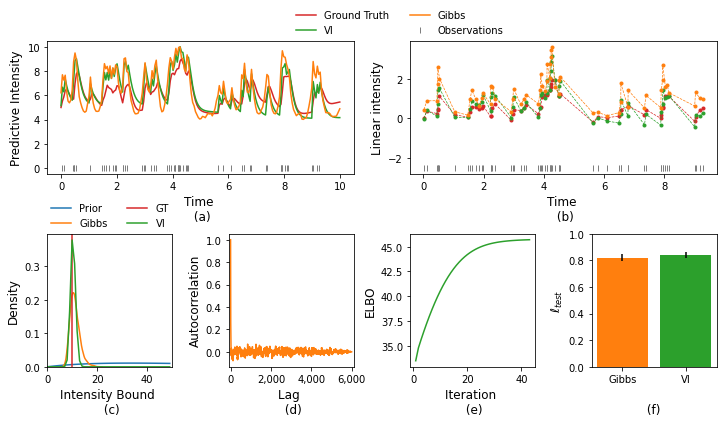

In [20]:
plot_for_res(intensities, predictive_intensities_vi_mean, 
             predictive_intensities_vi_var, predictive_density_gibbs_mean, 
             predictive_density_gibbs_var, x_grid, 
             gibbs_intensity_bound, intensity_bound_gt, lambda_a_prior, lambda_b_prior, 
             intensity_limit_vi_mean, LB_list, events, mu_g_X, phis_gt, gibbs_phis_mean, alpha_q1, beta_q1)